In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from joblib import Parallel, delayed

In [38]:
with open('./dataset/cleaned_datasets.pkl', 'rb') as f:
    datasets = pickle.load(f)
    
min_max_train_df = datasets['min_max_scale_pca']['train']
standard_train_df = datasets['standard_scale_pca']['train']

# Remove the Churn column
min_max_train_df = min_max_train_df.drop(columns=['Churn'])
standard_train_df = standard_train_df.drop(columns=['Churn'])

In [39]:
min_max_train_df.head(3)

,State_freq,State_churn_prob,Account length,International plan,Number vmail messages,Total day minutes,Total day calls,Total eve minutes,Total eve calls,Total night minutes,Total night calls,Total intl minutes
0,0.019505,0.192308,0.524793,0,0.50,0.755701,0.68750,0.542755,0.582353,0.572161,0.436090,0.500
1,0.024756,0.151515,0.438017,0,0.52,0.460661,0.76875,0.537531,0.605882,0.599772,0.526316,0.685
2,0.018755,0.280000,0.561983,0,0.00,0.693843,0.71250,0.333242,0.647059,0.338457,0.533835,0.610


In [40]:
standard_train_df.head(3)

,State_freq,State_churn_prob,Account length,International plan,Number vmail messages,Total day minutes,Total day calls,Total eve minutes,Total eve calls,Total night minutes,Total night calls,Total intl minutes
0,0.019505,0.192308,0.692163,0,1.247508,1.579670,0.484868,-0.058619,-0.050781,0.857403,-0.469031,-0.085020
1,0.024756,0.151515,0.161278,0,1.320985,-0.329918,1.135375,-0.095916,0.147654,1.048458,0.149054,1.242179
2,0.018755,0.280000,0.919686,0,-0.589414,1.179302,0.685024,-1.554439,0.494917,-0.759668,0.200561,0.704125


Here we evaluates the clustering performance of the DBSCAN algorithm under two different data normalization methods: Min-Max Scaling and Standard Scaling.For each normalization method, the code:

- Varies the eps parameter from 0.1 to 10.1, in steps of 0.01 (start = 0.1, step = 0.01, num_steps = 1000),

- Fixes min_samples = 50,

- Applies DBSCAN clustering to the scaled dataset,

- Computes the Silhouette Score for each eps value (setting it to -1 when only one cluster is found),

- Stores the score for analysis and comparison.

In [49]:
def dbscan_silhouette_scores(data, start, step, num_steps=10, **params):
    silhouette_scores = []
    # print(np.arange(start, start + num_steps * step, step))
    for eps in np.arange(start, start + num_steps * step, step):
        params['eps'] = eps
        model = DBSCAN(**params)
        model.fit(data)

        # Compute silhouette score only if there are at least 2 clusters
        if len(set(model.labels_)) > 1:
            silhouette_scores.append(silhouette_score(data, model.labels_))
        else:
            silhouette_scores.append(-1)  # Avoid errors for single clusters
    return silhouette_scores

def plot_results(results_dict, metric_name, num_steps=10):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    for i, (scale_type, values) in enumerate(results_dict.items()):
        x_values = np.arange(values['start'], values['start'] + num_steps * values['step'], values['step'])
        ax[i].plot(x_values, values['results'], marker='o')
        ax[i].set_title(f'{scale_type} Scaled Data ({metric_name})')
        ax[i].set_xlabel('Number of Clusters' if 'KMeans' in metric_name else 'Epsilon (eps)')
        ax[i].set_ylabel(metric_name)
        ax[i].grid(True)
    
    plt.tight_layout()
    plt.show()


[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -0.19102370734041238, -0.146022170779414, -0.05551842320142096, 0.009085227834622579, 0.07288876595159129, 0.12200234369727178, 0.16594961441593828, 0.07935290986755236, 0.11701670114353036, 0.16831870600875887, 0.1950628594519254, 0.29158160188074794, 0.3258553780949857, 0.35472382180033357, 0.3298549284522595, 0.3570951337781133, 0.37766004606583053, 0.38994112058270064, 0.4008068639118902, 0.4039369143109364, 0.40948342357037704, 0.4111546485532357, 0.4127944810077687, 0.41447004466709586, 0.41469801726178196, 0.40860106092622056, 0.42456236388354884, 0.4255359655278629, 0.4311488332580413, 0.4311488332580413, 0.43041370164747617, 0.4264163751398097, 0.4264163751398097, 0.43995697966309344, 0.43995697966309344, 0.43995697966309344, 0.43995697966309344, 0.4377616752239756, 0.4546640455315904, 0.4546640455315904, 0.4546640455315904, 0.4546640455315904, 0.4546640455315904, 0.4546640455315904, 0.4546640455315904, 0.4546640455315904, 0

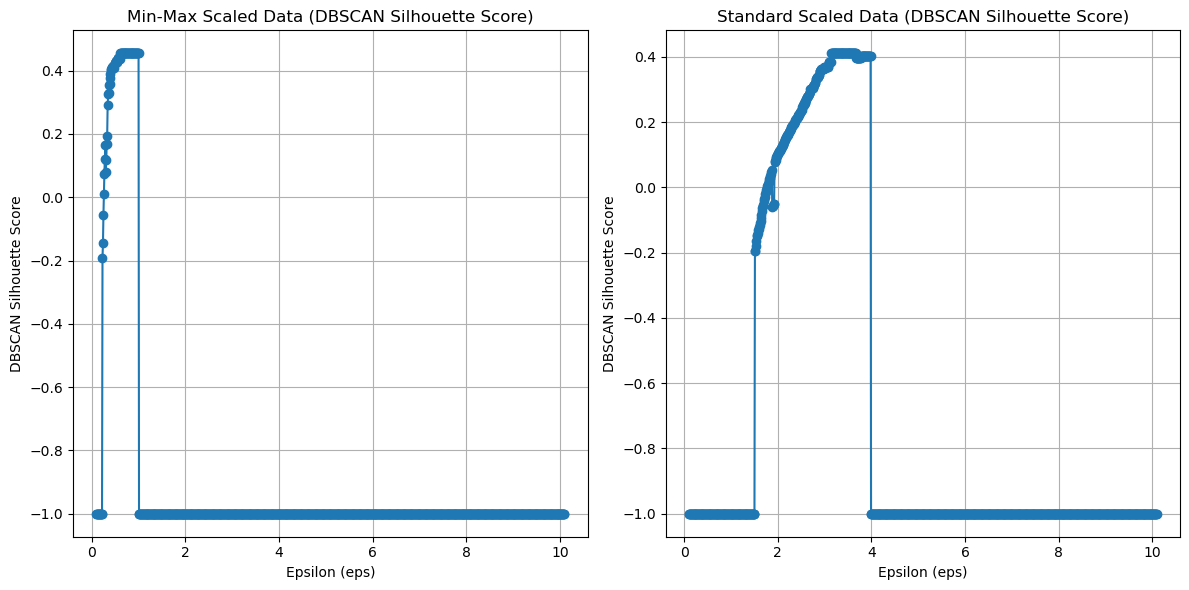

In [50]:
scaling_params = {
    'Min-Max': {'start': 0.1, 'step': 0.01},
    'Standard': {'start': 0.1, 'step': 0.01}
}

num_steps = 1000

scaling_params['Min-Max']['results'] = dbscan_silhouette_scores(min_max_train_df, start=scaling_params['Min-Max']['start'], step=scaling_params['Min-Max']['step'], num_steps=num_steps, min_samples=50)
scaling_params['Standard']['results'] = dbscan_silhouette_scores(standard_train_df, start=scaling_params['Standard']['start'], step=scaling_params['Standard']['step'], num_steps=num_steps, min_samples=50)

print(scaling_params['Min-Max']['results'], scaling_params['Standard']['results'])
plot_results(scaling_params, metric_name='DBSCAN Silhouette Score', num_steps=num_steps)

Based on the visualization results, we can initially identify the approximate range where the optimal eps value lies. In this analysis, we consider a Silhouette Score greater than 0.4 as an indicator of good clustering performance. Therefore, we further narrow down and examine the target interval where the score exceeds this threshold.

In [51]:
def get_threshold_eps_ranges(scores, start, step, threshold=0.4):
    eps_values = np.arange(start, start + len(scores) * step, step)
    high_eps = eps_values[np.array(scores) > threshold]

    if len(high_eps) == 0:
        return []

    ranges = []
    current_range = [high_eps[0]]

    for i in range(1, len(high_eps)):
        if np.isclose(high_eps[i], high_eps[i-1] + step):  # 连续
            continue
        else:
            current_range.append(high_eps[i-1])
            ranges.append(tuple(current_range))
            current_range = [high_eps[i]]

    current_range.append(high_eps[-1])
    ranges.append(tuple(current_range))

    return ranges


In [52]:
for scale_type in ['Min-Max', 'Standard']:
    start = scaling_params[scale_type]['start']
    step = scaling_params[scale_type]['step']
    scores = scaling_params[scale_type]['results']

    high_score_ranges = get_threshold_eps_ranges(scores, start, step, threshold=0.4)

    if high_score_ranges:
        print(f"\n[{scale_type}] Epsilon ranges with Silhouette Score > 0.4:")
        for r in high_score_ranges:
            print(f"  - Range: [{r[0]:.3f}, {r[1]:.3f}]")
    else:
        print(f"\n[{scale_type}] No eps range found with Silhouette Score > 0.4.")


[Min-Max] Epsilon ranges with Silhouette Score > 0.4:
  - Range: [0.410, 1.000]

[Standard] Epsilon ranges with Silhouette Score > 0.4:
  - Range: [3.140, 3.660]
  - Range: [3.780, 3.980]


For the Min-Max scaled data, the eps values yielding a Silhouette Score greater than 0.4 fall within the range [0.410, 1.000].For the Standard scaled data, two separate eps intervals meet the same criterion:[3.140, 3.660]
and [3.780, 3.980]

- Since these two ranges in the Standard scaling case are relatively close to each other, we will combine them into a single interval for further analysis in the next step.



In [53]:
# Compute the silhouette score for a single eps value
def compute_silhouette(data, eps, **params):
    params['eps'] = eps
    model = DBSCAN(**params)
    model.fit(data)
    if len(set(model.labels_)) > 1:
        return silhouette_score(data, model.labels_)
    else:
        return -1  # Return -1 if only one cluster (or all noise)

# Compute silhouette scores in parallel over a range of eps values
def dbscan_silhouette_scores_parallel(data, eps_values, **params):
    return Parallel(n_jobs=-1)(
        delayed(compute_silhouette)(data, eps, **params) for eps in eps_values
    )

# Extract the high-score eps range (e.g., within 95% of the best score)
def get_high_score_eps_range(eps_values, scores, top_percent=0.95):
    max_score = max(scores)
    threshold = top_percent * max_score
    high_score_indices = [i for i, s in enumerate(scores) if s >= threshold]
    if not high_score_indices:
        return None, None

    # Find the first continuous interval of high scores
    start_idx = high_score_indices[0]
    end_idx = start_idx
    for i in range(1, len(high_score_indices)):
        if high_score_indices[i] == high_score_indices[i - 1] + 1:
            end_idx = high_score_indices[i]
        else:
            break

    return eps_values[start_idx], eps_values[end_idx]

# Plot the results: silhouette score vs eps, highlight the best and high-score ranges
def plot_results(results_dict, metric_name):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    for i, (scale_type, values) in enumerate(results_dict.items()):
        eps_values = values['eps_range']
        scores = values['results']

        ax[i].plot(eps_values, scores, marker='o', label='Silhouette Score')
        ax[i].set_title(f'{scale_type} Scaled Data ({metric_name})')
        ax[i].set_xlabel('Epsilon (eps)')
        ax[i].set_ylabel(metric_name)
        ax[i].grid(True)

        # Mark the best silhouette score
        best_idx = np.argmax(scores)
        best_eps = eps_values[best_idx]
        best_score = scores[best_idx]
        ax[i].axvline(best_eps, color='red', linestyle='--',
                      label=f'Max: {best_score:.4f} at eps={best_eps:.2f}')
        print(f"[{scale_type}] Best eps: {best_eps:.3f}, Silhouette Score: {best_score:.4f}")

        # Mark the high-score eps interval
        low_eps, high_eps = get_high_score_eps_range(eps_values, scores, top_percent=0.95)
        if low_eps is not None:
            ax[i].axvspan(low_eps, high_eps, color='orange', alpha=0.2,
                          label=f'High-Score Range: [{low_eps:.2f}, {high_eps:.2f}]')
            print(f"[{scale_type}] Recommended eps range: [{low_eps:.3f}, {high_eps:.3f}]")

        ax[i].legend()

    plt.tight_layout()
    plt.show()


[Min-Max] Best eps: 0.601, Silhouette Score: 0.4547
[Min-Max] Recommended eps range: [0.552, 1.000]
[Standard] Best eps: 3.136, Silhouette Score: 0.4111
[Standard] Recommended eps range: [3.136, 3.982]


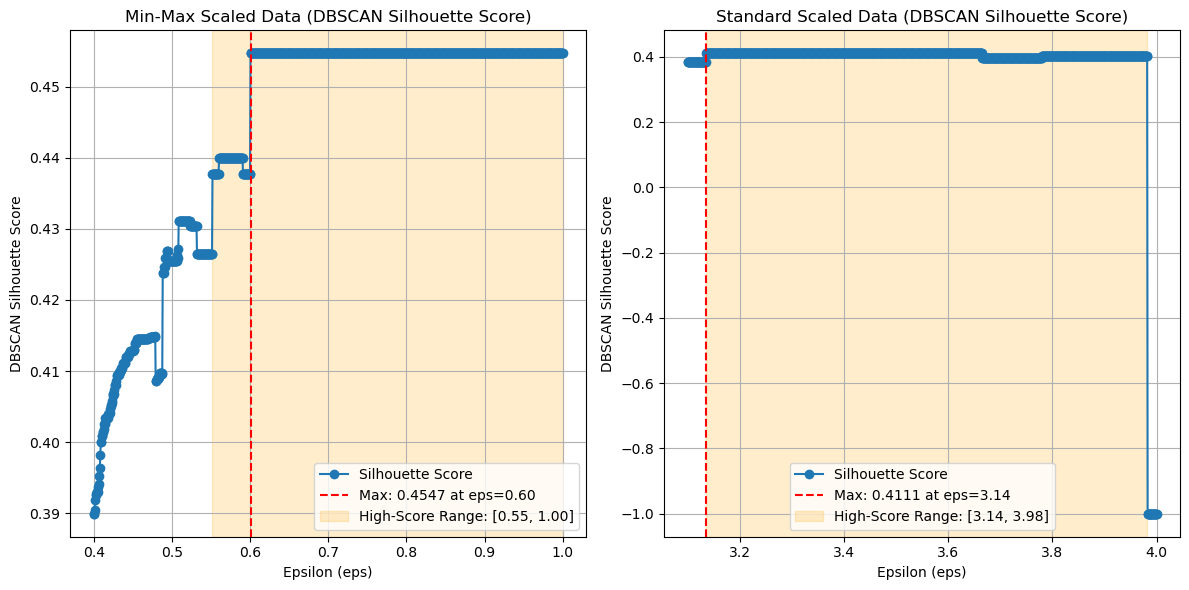

In [55]:
# Configuration for each scaling method
scaling_params = {
    'Min-Max': {
        'eps_range': np.linspace(0.4, 1.0, 1000),
        'dbscan_params': {'min_samples': 50}
    },
    'Standard': {
        'eps_range': np.linspace(3.1, 4, 1000),
        'dbscan_params': {'min_samples': 50}
    }
}

# Provide the corresponding scaled datasets
train_data_dict = {
    'Min-Max': min_max_train_df,
    'Standard': standard_train_df
}

# Run DBSCAN clustering and silhouette scoring
for scale_type in scaling_params:
    eps_range = scaling_params[scale_type]['eps_range']
    params = scaling_params[scale_type]['dbscan_params']
    data = train_data_dict[scale_type]
    scaling_params[scale_type]['results'] = dbscan_silhouette_scores_parallel(data, eps_range, **params)

# Plot results with max score and recommended eps interval
plot_results(scaling_params, metric_name='DBSCAN Silhouette Score')

The figure above compares the DBSCAN Silhouette Scores across a range of eps values for two different data normalization methods: Min-Max Scaling (left) and Standard Scaling (right).

For the Min-Max Scaled Data:

- The Silhouette Score exceeds 0.4 in the range [0.55, 1.00].

- The maximum score observed is 0.4547 at eps = 0.60.

- The score increases steadily before plateauing in the high-score region.

For the Standard Scaled Data:

- The Silhouette Score is greater than 0.4 across the interval [3.14, 3.98].

- The highest score is 0.4111 at eps = 3.14.


We perform DBSCAN clustering on both the Min-Max scaled and Standard scaled datasets using their respective optimal eps values. Under this condition, we calculate the number of clusters without excluding noise points, treating all noise points as belonging to a single additional cluster.

In [66]:
best_eps_min_max = 0.6
best_eps_standard = 3.14
min_samples = 50

# Apply DBSCAN and get labels
labels_min_max = DBSCAN(eps=best_eps_min_max, min_samples=min_samples).fit(min_max_train_df).labels_
labels_standard = DBSCAN(eps=best_eps_standard, min_samples=min_samples).fit(standard_train_df).labels_

# Count the number of clusters 
n_clusters_incl_noise_min_max = len(set(labels_min_max)) 
n_clusters_incl_noise_standard = len(set(labels_standard)) 

print(f"Number of clusters under Min-Max Normalization: {n_clusters_incl_noise_min_max}")
print(f"Number of clusters under Standard Normalization: {n_clusters_incl_noise_standard}")

Number of clusters under Min-Max Normalization: 3
Number of clusters under Standard Normalization: 2


In [67]:
best_eps_min_max = 0.6
best_eps_standard = 3.14
min_samples = 50

# Apply DBSCAN and get labels
labels_min_max = DBSCAN(eps=best_eps_min_max, min_samples=min_samples).fit(min_max_train_df).labels_
labels_standard = DBSCAN(eps=best_eps_standard, min_samples=min_samples).fit(standard_train_df).labels_

# Count the number of clusters (excluding noise points labeled as -1)
n_clusters_min_max = len(set(labels_min_max)) - (1 if -1 in labels_min_max else 0)
n_clusters_standard = len(set(labels_standard)) - (1 if -1 in labels_standard else 0)

print(f"Number of clusters(excluding noise) under Min-Max Normalization: {n_clusters_min_max}")
print(f"Number of clusters(excluding noise) under Standard Normalization: {n_clusters_standard}")

Number of clusters(excluding noise) under Min-Max Normalization: 2
Number of clusters(excluding noise) under Standard Normalization: 1


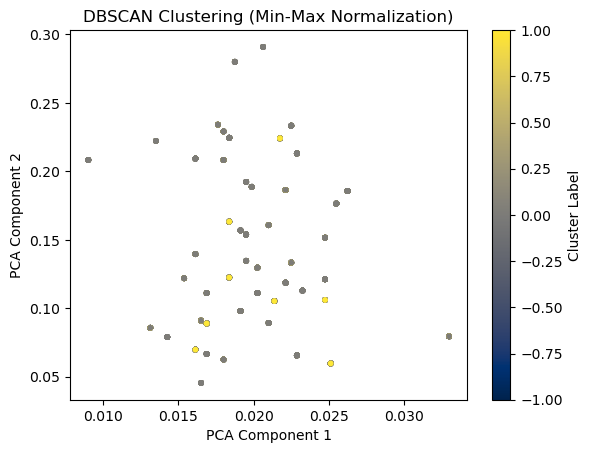

In [76]:
plt.scatter(min_max_train_df.iloc[:, 0], min_max_train_df.iloc[:, 1], c=labels_min_max, cmap='cividis', s=10)
plt.title('DBSCAN Clustering (Min-Max Normalization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

Cluster
0    2396
1     269
Name: count, dtype: int64


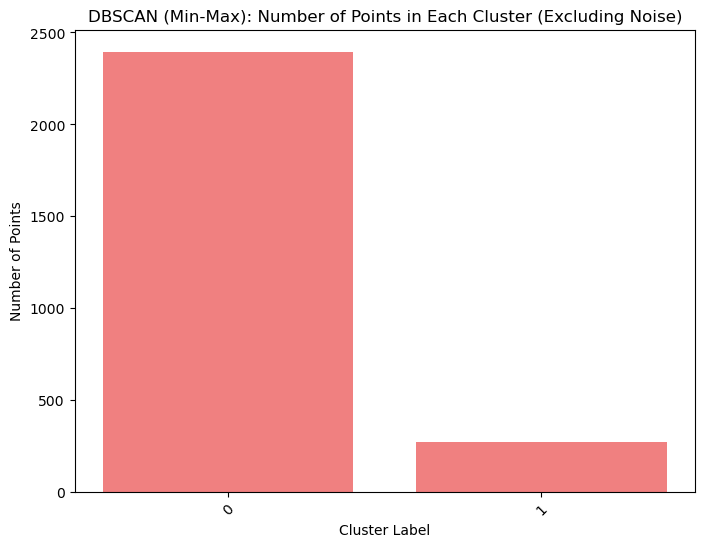

Feature means by cluster (excluding noise):
         Account length     Churn  International plan  Number vmail messages  \
Cluster                                                                        
0              0.410310  0.112688                 0.0               0.159900   
1              0.424621  0.434944                 1.0               0.162677   

         State_churn_prob  State_freq  Total day calls  Total day minutes  \
Cluster                                                                     
0                0.144957    0.020408         0.627118           0.509065   
1                0.150400    0.020403         0.625604           0.534342   

         Total eve calls  Total eve minutes  Total intl minutes  \
Cluster                                                           
0               0.587965           0.549714            0.509364   
1               0.591537           0.561555            0.532193   

         Total night calls  Total night minutes  
Cluster

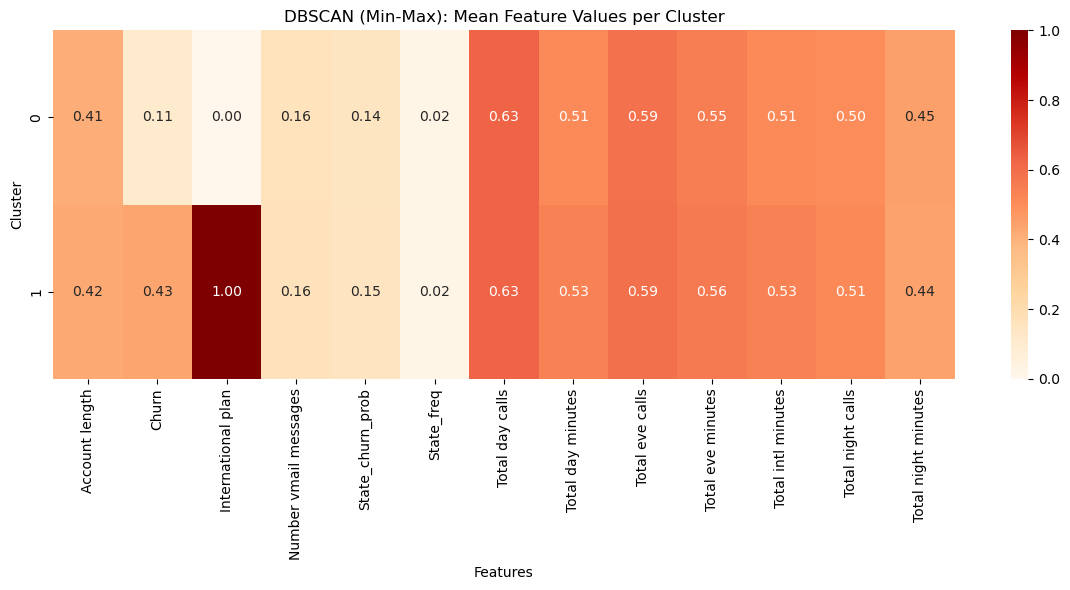

In [86]:
import seaborn as sns

min_max_train_df = datasets['min_max_scale_pca']['train']
standard_train_df = datasets['standard_scale_pca']['train']

# Copy the Min-Max scaled training data
dbscan_minmax_df = min_max_train_df.copy()
dbscan_minmax_df['Cluster'] = labels_min_max  # Assign DBSCAN cluster labels

# Count the number of samples in each cluster (excluding noise, i.e., label -1)
filtered_df = dbscan_minmax_df[dbscan_minmax_df['Cluster'] != -1]  # Exclude noise points
cluster_counts = filtered_df['Cluster'].value_counts().sort_index()  # Count samples per cluster
print(cluster_counts)

# Plot the number of points in each cluster
plt.figure(figsize=(8, 6))
plt.bar(cluster_counts.index.astype(str), cluster_counts.values, color='lightcoral')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Points')
plt.title('DBSCAN (Min-Max): Number of Points in Each Cluster (Excluding Noise)')
plt.xticks(rotation=45)
plt.show()

# Calculate the mean feature values for each cluster (excluding noise)
filtered_df = dbscan_minmax_df[dbscan_minmax_df['Cluster'] != -1]
cluster_summary = filtered_df.groupby('Cluster').mean().sort_index(axis=1)

print("Feature means by cluster (excluding noise):")
print(cluster_summary)

# Plot a heatmap of cluster-wise average feature values
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_summary, annot=True, cmap='OrRd', fmt=".2f")
plt.title("DBSCAN (Min-Max): Mean Feature Values per Cluster")
plt.xlabel("Features")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()



The above figures show the number of points in each of the two clusters obtained using the Min-Max normalization method after excluding noise, as well as the mean feature values per cluster including the churn feature. It can be observed that the most significant difference between clusters lies in the International Plan, while the smallest difference is in State Frequency (state_freq).